In [1]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import nibabel as nib
import cv2
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler
from torchvision.utils import save_image

In [2]:
# Path to the root directory containing MRI test data (NIfTI files)
DATA_ROOT       = "/kaggle/input/datamri/datatest"

# Input image size (must match the architecture of Generator/Discriminator)
IMG_SIZE        = 128

# Latent dimension for prior_G (must match what was used during prior training)
LATENT_SIZE_PRIOR = 128

# Basic model parameters
IMG_CHANNELS    = 1       # MRI images have a single channel
FEATURES_G      = 64      # Base number of filters for the Generator
FEATURES_D      = 64      # Base number of filters for the Discriminator

# Hyperparameters for training the prior GAN
BATCH_SIZE      = 64      # Batch size for DataLoader
LR_PRIOR        = 2e-4    # Learning rate for prior_G and critic optimizer
BETAS_PRIOR     = (0.5, 0.999)  # Adam optimizer betas (beta1, beta2)
EPOCHS_PRIOR    = 50       # Number of training epochs for the prior (adjust based on GPU availability)

# Directory to save checkpoints of prior_G during training (if desired)
PRIOR_SAVE_DIR  = "/kaggle/working/"

# Checkpoint path for the target WGAN-GP model used in the inversion attack
WGAN_CKPT       = "/kaggle/input/wgan_dp_mri_230/pytorch/default/1/wgan_gp_mri_e230.pt"

# Directory to save inversion results (reconstructed images and tensors)
OUTPUT_DIR      = "/kaggle/working/"

# Device configuration: use CUDA if available, otherwise fall back to CPU
DEVICE          = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Enable cuDNN benchmark mode for optimized performance when input sizes are fixed
torch.backends.cudnn.benchmark = True


### Function Overview
The purpose of collect_and_preprocess_slices is to:

1. Recursively search a given directory (root_dir) for all MRI volumes in NIfTI format (.nii and .nii.gz).

2. Extract a contiguous range of 2D slices from each 3D volume (defined by slice_range).

3. Apply windowing to each slice using the 2nd and 98th percentiles (to improve contrast).

4. Normalize the windowed slice values to the range [0,1]

5. Resize each slice to a square image of size img_size × img_size.

6. Scale the final resized image from [0,1] into [−1,1] (so it is compatible with GAN training).

7. Collect all processed slices into a single NumPy array of shape (N_slices, img_size, img_size).

If no valid slices are found, it will raise an error to alert the user that something went wrong in data collection or preprocessing.



In [3]:
def collect_and_preprocess_slices(root_dir, img_size=128, slice_range=(45, 75)):
    """
    - Recursively scan `root_dir` for all files ending in .nii or .nii.gz
    - For each 3D volume, extract slices in the z-index range [slice_range[0], slice_range[1])
    - Apply intensity windowing using the 2nd and 98th percentiles, normalize to [0, 1],
      then resize each slice to (img_size x img_size) and finally scale to [-1, 1].
    - Return a NumPy array of shape (N_slices, img_size, img_size), dtype=float32.
    """
    # -----------------------------------------
    # 1) Find all .nii and .nii.gz files under `root_dir`
    # -----------------------------------------
    nii_paths = []
    # We look for both extensions, allowing recursive search through subfolders.
    for ext in ("*.nii", "*.nii.gz"):
        # glob.glob(..., recursive=True) finds all matching files in subdirectories
        nii_paths.extend(glob.glob(os.path.join(root_dir, "**", ext), recursive=True))
    # If we didn’t find any NIfTI files, it likely means the path is wrong or empty
    if len(nii_paths) == 0:
        raise RuntimeError(f"No .nii or .nii.gz files found in {root_dir}")
    # Sort the file paths so that processing order is deterministic
    nii_paths.sort()

    # This list will hold every processed 2D slice (floats in [-1, 1])
    all_slices = []

    # -----------------------------------------
    # 2) Loop over each volume and extract slices
    # -----------------------------------------
    pbar = tqdm(nii_paths, desc="Collecting slices", unit="volume")
    for vol_path in pbar:
        try:
            # Load the 3D volume using nibabel → returns a NumPy array
            vol = nib.load(vol_path).get_fdata()
        except Exception:
            # If loading fails (e.g., corrupted file), skip this volume
            continue
        # Ensure the volume is indeed 3D; otherwise skip
        if vol.ndim != 3:
            continue

        # Determine the z-range safely: clip to [0, vol.shape[2] - 1]
        z_min, z_max = slice_range
        z_max = min(z_max, vol.shape[2] - 1)
        z_min = max(z_min, 0)

        # -----------------------------------------
        # 3) Process each 2D slice in [z_min, z_max)
        # -----------------------------------------
        for z in range(z_min, z_max):
            # Extract the raw 2D slice (shape: H × W, dtype depends on NIfTI data)
            slice_2d = vol[:, :, z]

            # ----- Windowing step -----
            # Compute the 2nd and 98th percentiles of the pixel intensities
            p2, p98 = np.percentile(slice_2d, (2, 98))
            # Clip intensities to [p2, p98], which enhances contrast
            slice_windowed = np.clip(slice_2d, p2, p98)

            # Avoid division by zero if p98 == p2 by adding a tiny epsilon
            denom = (p98 - p2) + 1e-6
            # Normalize intensities to [0, 1]
            slice_norm = (slice_windowed - p2) / denom

            # ----- Resize step -----
            # Convert to float32 (required by OpenCV) and resize to (img_size × img_size)
            slice_resized = cv2.resize(
                slice_norm.astype(np.float32),
                (img_size, img_size),
                interpolation=cv2.INTER_CUBIC
            )

            # ----- Scaling step -----
            # Scale pixel values from [0, 1] → [-1, 1] so they match the GAN’s expected input range
            slice_final = slice_resized * 2.0 - 1.0

            # Append the processed slice (float32) to the list
            all_slices.append(slice_final.astype(np.float32))

    # -----------------------------------------
    # 4) After processing all volumes, ensure we have at least one slice
    # -----------------------------------------
    if len(all_slices) == 0:
        raise RuntimeError("No slices were collected after preprocessing.")

    # Stack the list of 2D slices into a single NumPy array of shape (N, img_size, img_size)
    arr = np.stack(all_slices, axis=0)
    return arr


In [4]:
class Generator(nn.Module):
    def __init__(self, latent_size, img_channels, img_size, features_g=64):
        """
        Initialize the Generator network.

        Args:
            latent_size (int): Dimensionality of the input noise vector z.
            img_channels (int): Number of output image channels (e.g., 1 for grayscale).
            img_size (int): Height/width of the output image (assumes square images).
            features_g (int): Base number of feature maps for convolutional layers.
        """
        super(Generator, self).__init__()

        # Store image size and latent dimension
        self.img_size = img_size
        # We will upsample from a small spatial resolution. 
        # init_size = img_size / 16 is the starting height/width before successive ConvTranspose layers.
        self.init_size = img_size // 16  # e.g., if img_size = 128, init_size = 8
        self.latent_size = latent_size
        self.img_channels = img_channels

        # ------------------------------------------------------------------------------
        # 1) Fully Connected (Dense) layer to project the latent vector z into a 4D tensor
        # ------------------------------------------------------------------------------
        # - Input: vector of shape (batch_size, latent_size)
        # - Output: flattened features of size (features_g * 8 * init_size * init_size)
        #   which we will later reshape into (batch_size, features_g*8, init_size, init_size)
        self.fc = nn.Sequential(
            nn.Linear(latent_size, features_g * 8 * self.init_size * self.init_size),
            # BatchNorm on the flattened features to stabilize training
            nn.BatchNorm1d(features_g * 8 * self.init_size * self.init_size),
            # LeakyReLU activation introduces non-linearity; alpha=0.2 for negative slope
            nn.LeakyReLU(0.2, inplace=True)
        )

        # ------------------------------------------------------------------------------
        # 2) Transposed Convolutional blocks to progressively upsample the feature maps
        # ------------------------------------------------------------------------------
        # Each ConvTranspose2d layer doubles the spatial resolution (height & width).
        # We start with shape: (batch_size, features_g*8, init_size, init_size)
        # and end with (batch_size, img_channels, img_size, img_size).
        self.conv_blocks = nn.Sequential(
            # --------------------------------------------------------------------------
            # Block 1: Upsample from (init_size x init_size) -> (init_size*2 x init_size*2)
            # Input channels: features_g * 8
            # Output channels: features_g * 4
            # Kernel size 4, stride 2, padding 1 → doubles spatial dimensions
            # --------------------------------------------------------------------------
            nn.ConvTranspose2d(
                features_g * 8,            # in_channels
                features_g * 4,            # out_channels
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(features_g * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Now shape is (batch_size, features_g*4, init_size*2, init_size*2)

            # --------------------------------------------------------------------------
            # Block 2: Upsample from (init_size*2 x init_size*2) -> (init_size*4 x init_size*4)
            # Input channels: features_g * 4
            # Output channels: features_g * 2
            # --------------------------------------------------------------------------
            nn.ConvTranspose2d(
                features_g * 4,
                features_g * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(features_g * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Now shape is (batch_size, features_g*2, init_size*4, init_size*4)

            # --------------------------------------------------------------------------
            # Block 3: Upsample from (init_size*4 x init_size*4) -> (init_size*8 x init_size*8)
            # Input channels: features_g * 2
            # Output channels: features_g
            # --------------------------------------------------------------------------
            nn.ConvTranspose2d(
                features_g * 2,
                features_g,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(features_g),
            nn.LeakyReLU(0.2, inplace=True),
            # Now shape is (batch_size, features_g, init_size*8, init_size*8)

            # --------------------------------------------------------------------------
            # Block 4: Upsample from (init_size*8 x init_size*8) -> (img_size x img_size)
            # Input channels: features_g
            # Output channels: img_channels
            # Final activation is Tanh to map output pixels to [-1, 1].
            # --------------------------------------------------------------------------
            nn.ConvTranspose2d(
                features_g,
                img_channels,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.Tanh()  # Output images have pixel values in [-1, 1]
        )

        # Print summary of the Generator’s configuration
        print("Generator initialized:")
        print(f" - Latent size: {latent_size}")
        print(f" - Initial spatial size: {self.init_size} x {self.init_size}")
        print(f" - Base features (G): {features_g}")
        print(f" - Output image size: {img_size} x {img_size} x {img_channels}")

    def forward(self, z):
        """
        Forward pass through the Generator.

        Args:
            z (Tensor): Noise vector input, shape (batch_size, latent_size).

        Returns:
            Tensor: Generated image tensor, shape (batch_size, img_channels, img_size, img_size).
        """
        # 1) Project and reshape:
        #    - z → fc → flatten into (batch_size, features_g*8*init_size*init_size)
        #    - reshape to (batch_size, features_g*8, init_size, init_size)
        out = self.fc(z)
        out = out.view(out.size(0), -1, self.init_size, self.init_size)

        # 2) Pass through series of ConvTranspose2d blocks to upsample step-by-step
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self, img_channels, img_size, features_d=64):
        """
        Initialize the Discriminator (Critic) network.

        Args:
            img_channels (int): Number of channels of the input image (e.g., 1 for grayscale).
            img_size (int): Height/width of the input image (assumes square images).
            features_d (int): Base number of feature maps for convolutional layers.
        """
        super(Discriminator, self).__init__()

        # Store image dimensions and base channels
        self.img_size = img_size
        self.img_channels = img_channels

        # ------------------------------------------------------------------------------
        # 1) Convolutional blocks to progressively downsample the image
        # ------------------------------------------------------------------------------
        # Each Conv2d layer halves the spatial dimensions (height & width).
        # No BatchNorm here, as recommended for WGAN-GP’s Critic.
        self.conv_blocks = nn.Sequential(
            # --------------------------------------------------------------------------
            # Block 1: Downsample from (img_size x img_size) -> (img_size/2 x img_size/2)
            # Input channels: img_channels
            # Output channels: features_d
            # --------------------------------------------------------------------------
            nn.Conv2d(
                img_channels,     # in_channels
                features_d,       # out_channels
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True),
            # Now shape is (batch_size, features_d, img_size/2, img_size/2)

            # --------------------------------------------------------------------------
            # Block 2: Downsample from (img_size/2 x img_size/2) -> (img_size/4 x img_size/4)
            # Input channels: features_d
            # Output channels: features_d * 2
            # --------------------------------------------------------------------------
            nn.Conv2d(
                features_d,
                features_d * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True),
            # Now shape is (batch_size, features_d*2, img_size/4, img_size/4)

            # --------------------------------------------------------------------------
            # Block 3: Downsample from (img_size/4 x img_size/4) -> (img_size/8 x img_size/8)
            # Input channels: features_d * 2
            # Output channels: features_d * 4
            # --------------------------------------------------------------------------
            nn.Conv2d(
                features_d * 2,
                features_d * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True),
            # Now shape is (batch_size, features_d*4, img_size/8, img_size/8)

            # --------------------------------------------------------------------------
            # Block 4: Downsample from (img_size/8 x img_size/8) -> (img_size/16 x img_size/16)
            # Input channels: features_d * 4
            # Output channels: features_d * 8
            # --------------------------------------------------------------------------
            nn.Conv2d(
                features_d * 4,
                features_d * 8,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True),
            # Now shape is (batch_size, features_d*8, img_size/16, img_size/16)

            # --------------------------------------------------------------------------
            # Block 5: (Optional deeper block) Downsample from (img_size/16 x img_size/16) -> (img_size/32 x img_size/32)
            # Input channels: features_d * 8
            # Output channels: features_d * 16
            # --------------------------------------------------------------------------
            nn.Conv2d(
                features_d * 8,
                features_d * 16,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True)
            # Now shape is (batch_size, features_d*16, img_size/32, img_size/32)
        )

        # ------------------------------------------------------------------------------
        # 2) Final fully-connected layer to produce a single critic score per image
        # ------------------------------------------------------------------------------
        # After flattening, the input feature size is:
        #   features_d * 16 * (img_size/32) * (img_size/32)
        final_feature_map_size = img_size // 32  # e.g., 128//32 = 4
        self.fc = nn.Sequential(
            nn.Flatten(),
            # Optionally, one could insert an intermediate FC + activation, but here we go directly:
            nn.Linear(
                features_d * 16 * final_feature_map_size * final_feature_map_size,
                1
            )
            # No activation (e.g., no Sigmoid), because WGAN’s critic outputs a real-valued score
        )

        # Print a summary of the Discriminator’s configuration
        print("Discriminator (Critic) initialized:")
        print(f" - Input image size: {img_size} x {img_size} x {img_channels}")
        print(f" - Base features (D): {features_d}")
        print(f" - Final feature map size before flatten: {final_feature_map_size} x {final_feature_map_size}")
        print(" - Output: Single scalar critic score per image")

    def forward(self, img):
        """
        Forward pass through the Discriminator (Critic).

        Args:
            img (Tensor): Input image tensor (real or generated), 
                          shape (batch_size, img_channels, img_size, img_size).

        Returns:
            Tensor: Critic score tensor of shape (batch_size, 1).
        """
        # 1) Pass through convolutional blocks to downsample
        out = self.conv_blocks(img)

        # 2) Flatten and apply the final fully-connected layer
        score = self.fc(out)
        return score


The purpose of gradient_penalty is to enforce the Lipschitz constraint required by Wasserstein GAN with Gradient Penalty (WGAN-GP). Specifically, it computes the term:

$$
\mathrm{GP} \;=\; \lambda \;\mathbb{E}_{\hat{x}}\Bigl(\|\nabla_{\hat{x}} D(\hat{x})\|_{2} \;-\; 1\Bigr)^{2}
$$


where:

+ D is the critic (discriminator) network.

+ x̂ is an interpolated sample between a real image and a generated (fake) image.

+ λ (denoted by gp_lambda in the code) is the gradient penalty coefficient (commonly set to 10).

By adding this penalty to the critic’s loss during training, we ensure that the critic’s gradient norm remains close to 1 almost everywhere, which satisfies the 1-Lipschitz requirement of WGAN.




In [5]:
def gradient_penalty(critic, real, fake, device='cuda', gp_lambda=10):
    """
    Compute the gradient penalty for WGAN-GP.
    
    The gradient penalty is defined as:
        λ * (||∇_x̂ D(x̂)||_2 - 1)^2
    where x̂ is an interpolation between a real sample and a fake sample.
    
    Args:
        critic (nn.Module): The Discriminator (critic) network D.
        real (Tensor):   A batch of real images, shape (batch_size, C, H, W).
        fake (Tensor):   A batch of generated (fake) images, shape (batch_size, C, H, W).
        device (str or torch.device): Device to perform computations on ('cuda' or 'cpu').
        gp_lambda (float): Gradient penalty coefficient λ.
    
    Returns:
        Tensor: A scalar tensor representing the gradient penalty.
    """
    # --------------------------------------------------------------------------
    # 1) Determine batch size from the real images
    # --------------------------------------------------------------------------
    batch_size = real.size(0)

    # --------------------------------------------------------------------------
    # 2) Create random interpolation coefficients α in [0, 1]
    #    Shape: (batch_size, 1, 1, 1), so we can broadcast to image shape.
    # --------------------------------------------------------------------------
    alpha = torch.rand(batch_size, 1, 1, 1, device=device)

    # --------------------------------------------------------------------------
    # 3) Linearly interpolate between real and fake images:
    #       x̂ = α * real + (1 - α) * fake
    #    We call .requires_grad_(True) so that we can compute gradients w.r.t. x̂.
    # --------------------------------------------------------------------------
    interpolated = (alpha * real + (1 - alpha) * fake).requires_grad_(True)

    # --------------------------------------------------------------------------
    # 4) Compute critic scores on the interpolated images:
    #       D(x̂)
    # --------------------------------------------------------------------------
    prob_interpolated = critic(interpolated)

    # --------------------------------------------------------------------------
    # 5) Compute gradients of D(x̂) w.r.t. x̂:
    #    - outputs     = prob_interpolated (shape: batch_size × 1)
    #    - inputs      = interpolated (shape: batch_size × C × H × W)
    #    - grad_outputs= a tensor of ones with same shape as prob_interpolated
    #    - create_graph=True to enable higher-order derivative computation
    #    - retain_graph=True to keep the computation graph for potential further use
    #
    #    This returns a tuple; we take [0] to get the gradient tensor.
    # --------------------------------------------------------------------------
    grads = torch.autograd.grad(
        outputs=prob_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones_like(prob_interpolated),
        create_graph=True,
        retain_graph=True
    )[0]

    # --------------------------------------------------------------------------
    # 6) Reshape gradients to (batch_size, -1) so we can compute the norm per sample:
    #       Each row corresponds to all gradient values for one sample in the batch.
    # --------------------------------------------------------------------------
    grads = grads.view(batch_size, -1)

    # --------------------------------------------------------------------------
    # 7) Compute the L2 norm of each gradient vector (per sample):
    #       ‖∇_x̂ D(x̂)‖_2 
    #    Then compute (‖∇‖_2 - 1)^2, average over batch, and multiply by λ.
    # --------------------------------------------------------------------------
    grad_norm = grads.norm(2, dim=1)                    # Shape: (batch_size,)
    penalty_per_sample = (grad_norm - 1) ** 2            # Shape: (batch_size,)
    gp = gp_lambda * penalty_per_sample.mean()          # Scalar

    return gp


## invert\_wgan Function Explanation

The `invert_wgan` function implements a single-run model inversion attack on a target WGAN critic (discriminator) using a pre-trained generator. Its goal is to recover a latent vector **z** such that the generated image **G(z)** closely matches a given real image, while simultaneously maximizing the critic’s score for that generated image. This procedure can be used to approximately reconstruct a private (or hidden) image from access to the critic of a trained WGAN.

---

### Purpose

* **Recover a latent code**: Given a trained generator (prior) and access to the target discriminator (critic), find a latent vector **z** that “inverts” a real image back into the generator’s latent space.
* **Reconstruct and refine**: Use gradient‐based optimization to minimize a combination of reconstruction error (pixel‐wise similarity), latent‐norm regularization, and an adversarial objective (maximizing the critic’s confidence in the generated image).
* **Single seed run**: By fixing a random seed, the function produces a deterministic optimization path for **z**, but you can repeat with different seeds and pick the best result externally.

---

### Arguments

1. **D\_target**
   The target WGAN critic (instance of `Discriminator`) whose parameters are known. Must be set to evaluation mode (`.eval()`) before calling. We compute gradients through this critic to update **z**.

2. **prior\_G**
   A pre‐trained generator (instance of `Generator`) that maps a latent vector **z** to an image. Also must be in evaluation mode (`.eval()`). This network provides the mapping **z → image** during inversion.

3. **real\_{img}**
   A batch of real images that we wish to invert. Shape is `(batch_size, 1, H, W)`. Typically, `batch_size=1`, but the code handles any batch size. Pixel values should already be normalized to `[-1, 1]`.

4. **device**
   The computation device (`"cuda"` or `"cpu"`) on which both networks and tensors should reside. Pass `torch.device("cuda")` if a GPU is available.

5. **seed**
   An integer random seed used to initialize the latent vector **z**. Changing the seed results in a different random starting point for **z**.

6. **z\_{dim}** (default: 100)
   Dimensionality of the latent vector **z**. Must match the size expected by `prior_G`.

7. **steps** (default: 1000)
   Number of optimization steps to perform on the latent vector **z**.

8. **lr** (default: 1e-2)
   Learning rate for updating **z** via gradient descent with momentum.

9. **momentum** (default: 0.9)
   Momentum coefficient used in the Nesterov‐style update for **z**.

10. **lambda\_z** (default: 1e-4)
    Weight for the latent‐norm regularization term `lambda_z * ||z||^2`. This prevents **z** from drifting too far from the origin.

11. **lambda\_{recon}** (default: 100.0)
    Weight for the pixel‐wise reconstruction loss `lambda_recon * MSE(G(z), real_img)`.

12. **clip\_{range}** (default: 1.0)
    After every gradient update, **z** is clamped to the interval `[-clip_range, +clip_range]`. This ensures **z** stays within a bounded region.

---

### Internal Steps

1. **Preparation**

   * Put the generator `prior_G` into evaluation mode (`prior_G.eval()`).
   * Fix the random seed (`torch.manual_seed(seed)`) so that the initial latent vector **z** is reproducible.
   * Move `real_img` to the specified `device`.
   * Instantiate a mean‐squared error criterion:

     ```python
     mse_loss = nn.MSELoss()
     ```

2. **Initialize latent vector and momentum buffer**

   * Sample **z** from a standard normal distribution, then clamp:

     ```python
     z = torch.randn(batch_size, z_dim, device=device)
     z = z.clamp(-clip_range, clip_range)
     ```
   * Create a zero‐initialized momentum buffer `v` of the same shape:

     ```python
     v = torch.zeros_like(z)
     ```
   * Enable gradient tracking on **z**:

     ```python
     z.requires_grad_(True)
     ```
   * Prepare variables to record the best (lowest‐loss) reconstructed image so far:

     ```python
     best_img = None
     best_loss = float('inf')
     ```

3. **Main optimization loop (repeated for `steps` iterations)**
   In each iteration:

   1. **Generate a fake image** from the current **z**:

      ```python
      fake = prior_G(z)  # shape: (batch_size, 1, H, W)
      ```
   2. **Compute three loss components**:

      * **Adversarial loss:**

        $$
          l_{adv} = - E[D_{target}(fake)]  
        $$

        Encourages the critic to assign a high score to `fake`.

      * **Latent regularization:**

        $$
          l_{reg} = lambda_z * E[||z||^2]  
        $$

        Penalizes large values in **z**.

      * **Reconstruction loss:**

        $$
          l_{recon} = lambda_{recon} * MSE(fake, real_{img})  
        $$

        Enforces pixel‐wise similarity between `fake` and the original `real_img`.
   3. **Combine** these terms into a single total loss:

      $$
        l_{total} = l_{adv} + l_{reg} + l_{recon}.  
      $$
   4. **Backpropagate** to compute $
      abla_z \, l_{total}$ by calling:

      ```python
      loss.backward()
      ```
   5. **Update the latent vector** **z** using a momentum‐style rule:

      * Let `g = ∂l_{total}/∂z`.
      * Save previous momentum: `v_{prev} = v.clone()`.
      * Update momentum:

        $$
          v = momentum * v - lr * g  
        $$
      * Nesterov‐style update for **z**:

        $$
          z = z + (-momentum * v_{prev} + (1 + momentum) * v)  
        $$
      * Detach from the old computation graph, then clamp **z** to `[-clip_range, clip_range]`, and re‐enable `requires_grad`:

        ```python
        z = z.detach().clamp(-clip_range, clip_range).requires_grad_(True)
        ```
   6. **Track the best reconstruction**

      * If the current total loss is lower than `best_loss`, update `best_loss` and store a CPU copy of `fake` as `best_img`.
   7. **Zero gradients** on both the generator and critic to prepare for the next iteration:

      ```python
      prior_G.zero_grad()
      D_target.zero_grad()
      ```

4. **Finalize and return**

   * After all `steps` iterations, return `prior_G` to training mode:

     ```python
     prior_G.train()
     ```
   * Return the best reconstructed image found during optimization. It will be a CPU tensor of shape `(batch_size, 1, H, W)`.

---

### Return Value

* **best\_img**: A CPU tensor containing the reconstructed image(s) that achieved the lowest total loss during the optimization loop. Shape is `(batch_size, 1, H, W)`. These pixel values remain in the range `[-1, 1]`, identical to the generator’s output scale.

---

### Usage Guide

Include this description in your repository’s README to explain:

1. **What** `invert_wgan` does: a single‐seed model inversion attack on a trained WGAN critic.
2. **Why** it works: optimizing latent **z** under combined adversarial, reconstruction, and regularization losses.
3. **Inputs** required: a trained critic (`D_target`), a pre‐trained generator (`prior_G`), and a real image tensor.
4. **Outputs** produced: the best reconstructed image(s) in CPU memory.

This gives readers enough context to understand how to call `invert_wgan` and how it fits into a model inversion pipeline.


In [6]:
def invert_wgan(
    D_target,        # The target critic (Discriminator) we want to invert. It must be in eval mode.
    prior_G,         # A pre-trained Generator (prior) that maps latent z → image.
    real_img,        # A batch of “real” images to reconstruct, shape: (batch_size, 1, H, W).
                     #    Typically, batch_size=1, but the function handles any batch dimension.
    device,          # Device on which to perform computations (e.g., 'cuda' or 'cpu').
    seed,            # Random seed for reproducibility (affects initial z).
    z_dim=100,       # Dimensionality of the latent vector z.
    steps=1000,      # Number of optimization steps to run.
    lr=1e-2,         # Learning rate for updating z.
    momentum=0.9,    # Momentum coefficient for the z update.
    lambda_z=1e-4,   # Weight for the latent regularization term (||z||²).
    lambda_recon=100.0,  # Weight for the reconstruction loss (MSE(fake, real_img)).
    clip_range=1.0   # Range to clamp z after each update ([-clip_range, +clip_range]).
):
    """
    Perform a single model inversion run with a fixed random seed.

    - D_target: the WGAN critic we have access to (state loaded, in eval mode).
    - prior_G: the pre-trained WGAN generator (the “prior”) in eval mode.
    - real_img: tensor containing one or more real images to invert, shape (N, 1, H, W).
    
    Returns:
        best_img (Tensor): The best reconstructed image(s) found during optimization,
                           shape (batch_size, 1, H, W), moved to CPU.
    """
    # ------------------------------------------------------------------------------
    # 1) Prepare generator and set random seed
    # ------------------------------------------------------------------------------
    prior_G.eval()                   # Ensure the prior generator is in evaluation mode
    torch.manual_seed(seed)          # Fix random seed so initial z is reproducible

    # Move real images to the correct device (GPU or CPU)
    real_img = real_img.to(device)

    # Mean squared error loss for reconstruction
    mse_loss = nn.MSELoss()

    # ------------------------------------------------------------------------------
    # 2) Initialize latent vector z and momentum vector v
    # ------------------------------------------------------------------------------
    # z: random normal initialization, then clamped to [-clip_range, +clip_range]
    z = torch.randn(real_img.size(0), z_dim, device=device)
    z = z.clamp(-clip_range, clip_range)

    # v: momentum buffer, starts at zeros (same shape as z)
    v = torch.zeros_like(z)

    # Enable gradient computation on z so we can optimize it
    z.requires_grad_(True)

    # Variables to track the best reconstruction
    best_img = None
    best_loss = float('inf')

    # ------------------------------------------------------------------------------
    # 3) Main optimization loop: update z for a fixed number of steps
    # ------------------------------------------------------------------------------
    for i in range(steps):
        # ---- 3a) Generate a fake image from current z ----
        fake = prior_G(z)  # shape: (batch_size, 1, H, W)

        # ---- 3b) Compute adversarial loss: negative critic score on fake ----
        # D_target(fake) returns a critic score per image; .mean() takes the batch average
        loss_adv = -D_target(fake).mean()

        # ---- 3c) Compute latent regularization: λ_z * mean(z^2) ----
        loss_reg = lambda_z * (z ** 2).mean()

        # ---- 3d) Compute reconstruction loss: λ_recon * MSE(fake, real_img) ----
        loss_recon = lambda_recon * mse_loss(fake, real_img)

        # ---- 3e) Sum all losses ----
        loss = loss_adv + loss_reg + loss_recon

        # ---- 3f) Backpropagate to compute gradients ∂loss/∂z ----
        loss.backward()

        # ------------------------------------------------------------------------------
        # 4) Momentum-based update for z
        # ------------------------------------------------------------------------------
        # g: gradient of the loss w.r.t. z
        g = z.grad

        # Keep a copy of old momentum (v_prev) for the “Nesterov”‐style update
        v_prev = v.clone()

        # Update momentum buffer: v ← momentum * v + (−lr) * g
        # Note: alpha = −lr, so v.add_(g, alpha=−lr) is equivalent to v = momentum*v − lr * g
        v.mul_(momentum).add_(g, alpha=-lr)

        # Update z using the Nesterov-style formula:
        #    z ← z + (−momentum * v_prev + (1 + momentum) * v)
        z = z + (-momentum * v_prev + (1 + momentum) * v)

        # Detach z from the old graph, re-enable requires_grad, then clamp to valid range
        z = z.detach().clamp(-clip_range, clip_range).requires_grad_(True)

        # ------------------------------------------------------------------------------
        # 5) Track the best reconstructed image (lowest total loss)
        # ------------------------------------------------------------------------------
        if loss.item() < best_loss:
            best_loss = loss.item()
            # Detach, move to CPU, and store a copy of fake as the best current reconstruction
            best_img = fake.detach().cpu()

        # ------------------------------------------------------------------------------
        # 6) Zero out gradients for the next iteration
        # ------------------------------------------------------------------------------
        prior_G.zero_grad()
        D_target.zero_grad()

    # ------------------------------------------------------------------------------
    # 7) After optimization, switch the generator back to training mode
    # ------------------------------------------------------------------------------
    prior_G.train()

    # Return the best reconstructed image found
    return best_img  # Tensor on CPU, shape (batch_size, 1, H, W)


In [7]:
def train_prior_amp(
    processed_slices_np: np.ndarray,
    latent_size: int = 128,
    img_channels: int = 1,
    img_size: int = 128,
    features_g: int = 64,
    features_d: int = 64,
    batch_size: int = 64,
    lr: float = 2e-4,
    betas: tuple = (0.5, 0.999),
    epochs: int = 100,
    save_dir: str = None,
    device: torch.device = torch.device("cuda")
) -> (torch.nn.Module, torch.nn.Module):
    """
    Train a WGAN-GP prior generator (prior_G) using Automatic Mixed Precision (AMP).

    - processed_slices_np: numpy array of shape (N, img_size, img_size), values in [-1, 1].
    - latent_size, img_channels, img_size: match the Generator/Discriminator definitions.
    - features_g, features_d: base number of filters for Generator and Discriminator.
    - batch_size, lr, betas, epochs: training hyperparameters.
    - save_dir: if not None, save a checkpoint of prior_G every 20 epochs.
    - device: 'cuda' or 'cpu' where training will run.
    """
    # 1) Create a DataLoader from the preprocessed NumPy slices
    #    - Convert to a Torch tensor with shape (N, 1, img_size, img_size)
    img_tensor = torch.from_numpy(processed_slices_np).unsqueeze(1)  # shape: (N, 1, H, W)
    dataset = TensorDataset(img_tensor)
    loader  = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

    # 2) Initialize the Generator (prior_G) and Discriminator (critic) on the chosen device
    prior_G = Generator(latent_size, img_channels, img_size, features_g).to(device)
    critic  = Discriminator(img_channels, img_size, features_d).to(device)

    # 3) Create Adam optimizers for both G and D
    opt_G = optim.Adam(prior_G.parameters(), lr=lr, betas=betas)
    opt_D = optim.Adam(critic.parameters(),    lr=lr, betas=betas)

    # 4) Set up gradient scalers for Automatic Mixed Precision
    scaler_G = GradScaler()
    scaler_D = GradScaler()

    # 5) Start the training loop
    for ep in range(epochs):
        #    Wrap the DataLoader for a tqdm progress bar
        loop = tqdm(loader, desc=f"[AMP] Epoch {ep+1}/{epochs}", unit="batch")
        for (real_batch,) in loop:
            # ---- Update Discriminator (critic) ----
            # Move the real image batch to the device
            real = real_batch.to(device)  # shape: (B, 1, img_size, img_size)

            # Sample noise for generating fake images
            z = torch.randn(real.size(0), latent_size, device=device)

            with autocast():
                # Generate fake images and detach from gradient for D update
                fake = prior_G(z).detach()
                # Compute gradient penalty for real vs fake images
                gp = gradient_penalty(critic, real, fake, device=device, gp_lambda=10.0)
                # WGAN-GP discriminator loss:
                #   E[D(fake)] - E[D(real)] + λ * gradient_penalty
                loss_D = critic(fake).mean() - critic(real).mean() + gp

            # Zero out D’s gradients, scale loss, backpropagate, and step optimizer
            opt_D.zero_grad()
            scaler_D.scale(loss_D).backward()
            scaler_D.step(opt_D)
            scaler_D.update()

            # ---- Update Generator (prior_G) ----
            z2 = torch.randn(real.size(0), latent_size, device=device)
            with autocast():
                # Generate a new batch of fake images
                fake2 = prior_G(z2)
                # WGAN-GP generator loss: -E[D(fake2)]
                loss_G = -critic(fake2).mean()

            # Zero out G’s gradients, scale loss, backpropagate, and step optimizer
            opt_G.zero_grad()
            scaler_G.scale(loss_G).backward()
            scaler_G.step(opt_G)
            scaler_G.update()

            # Update tqdm with current losses for display
            loop.set_postfix({
                "Loss_D": f"{loss_D.item():.4f}",
                "Loss_G": f"{loss_G.item():.4f}"
            })

        # 6) Save a checkpoint of the prior_G every 20 epochs if save_dir is provided
        if (ep + 1) % 10 == 0 and (save_dir is not None):
            os.makedirs(save_dir, exist_ok=True)
            ckpt_path = os.path.join(save_dir, f"prior_amp_ep{ep+1}.pth")
            torch.save(prior_G.state_dict(), ckpt_path)
            print(f"[AMP] Saved prior_G checkpoint at epoch {ep+1} → {ckpt_path}")

    # 7) Training complete
    print("[AMP] Finished training prior_G.")
    return prior_G, critic


In [8]:
# Create the output directory if it doesn't already exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# If a directory for saving the prior checkpoints is specified, create it as well
if PRIOR_SAVE_DIR:
    os.makedirs(PRIOR_SAVE_DIR, exist_ok=True)

# -----------------------------------------------
# 7.1. Preprocess the MRI data
# -----------------------------------------------
print("==> Starting MRI data preprocessing ...")

# Call the collect_and_preprocess_slices function to:
#   1. Scan DATA_ROOT for all .nii / .nii.gz files
#   2. Extract slices in the range [45, 75) along the z-axis
#   3. Apply windowing (2nd and 98th percentile), normalize to [0,1], resize to IMG_SIZE, then scale to [-1,1]
processed_np = collect_and_preprocess_slices(
    DATA_ROOT,
    img_size=IMG_SIZE,
    slice_range=(45, 75)
)

# Print how many 2D slices were collected and confirm the size of each slice
print(f"  → Preprocessing complete. Total slices: {processed_np.shape[0]} (each {IMG_SIZE}×{IMG_SIZE}).")

# -----------------------------------------------
# 7.2. Train the prior generator (WGAN-GP) with AMP
# -----------------------------------------------
print("\n==> Starting to train prior_G (WGAN-GP + AMP) ...")

# Call train_prior_amp to train a WGAN-GP on the preprocessed MRI slices:
#   - processed_np is a NumPy array of shape (N, IMG_SIZE, IMG_SIZE), values in [-1,1]
#   - latent_size, img_channels, img_size, features_g, features_d set the architecture
#   - batch_size, lr, betas, epochs control the training
#   - save_dir determines where to save checkpoints every 20 epochs
#   - device specifies 'cuda' or 'cpu'
prior_G, critic_prior = train_prior_amp(
    processed_np,
    latent_size=LATENT_SIZE_PRIOR,
    img_channels=IMG_CHANNELS,
    img_size=IMG_SIZE,
    features_g=FEATURES_G,
    features_d=FEATURES_D,
    batch_size=BATCH_SIZE,
    lr=LR_PRIOR,
    betas=BETAS_PRIOR,
    epochs=EPOCHS_PRIOR,
    save_dir=PRIOR_SAVE_DIR,
    device=DEVICE
)

# -----------------------------------------------
# 7.3. Load the target WGAN-GP model (only need the Discriminator)
# -----------------------------------------------
print("\n==> Loading target WGAN-GP checkpoint ...")

# Load the checkpoint file for the target WGAN-GP (both G and D are stored inside)
# map_location ensures the weights are loaded onto the correct device
ckpt = torch.load(WGAN_CKPT, map_location=DEVICE)

# Extract the latent dimension from the saved generator weights:
#   - We know the first linear layer weight in G has shape (out_features, latent_dim)
latent_target = ckpt['generator_state_dict']['fc.0.weight'].size(1)

# Reconstruct the target Generator and Discriminator architecture using the same latent size
G_target = Generator(latent_target, IMG_CHANNELS, IMG_SIZE).to(DEVICE)
D_target = Discriminator(IMG_CHANNELS, IMG_SIZE).to(DEVICE)

# Load the saved state dictionaries into those model instances
G_target.load_state_dict(ckpt['generator_state_dict'])
D_target.load_state_dict(ckpt['discriminator_state_dict'])

# Put both models into evaluation mode (we will only use D_target for inversion)
G_target.eval()
D_target.eval()

print(f"  → Finished loading target WGAN-GP (latent dim = {latent_target}).")

# -----------------------------------------------
# 7.4. Perform the inversion attack on a subset of slices
# -----------------------------------------------
print("\n==> Starting inversion attack ...")

# Decide how many slices to invert (up to 50 or the total number of slices, whichever is smaller)
num_inv = min(50, processed_np.shape[0])

# Convert the preprocessed NumPy array into a Torch tensor of shape (N, 1, IMG_SIZE, IMG_SIZE)
tensor_slices = torch.from_numpy(processed_np).unsqueeze(1)

# Create a TensorDataset and DataLoader to iterate through slices one at a time (batch_size=1)
ds_inv = TensorDataset(tensor_slices)
loader_inv = DataLoader(ds_inv, batch_size=1, shuffle=True)

# Make a subfolder "recovered" inside OUTPUT_DIR to save reconstructed images and tensors
os.makedirs(os.path.join(OUTPUT_DIR, "recovered"), exist_ok=True)

inv_count = 0

# Loop over the DataLoader, stopping once we have inverted num_inv slices
for idx, (real_batch,) in enumerate(loader_inv):
    if inv_count >= num_inv:
        break

    # Move the single real image (shape: (1, 1, IMG_SIZE, IMG_SIZE)) to the device
    real_img = real_batch.to(DEVICE)

    # Initialize variables to keep track of the best reconstruction
    best_mse = float('inf')
    best_rec = None
    best_seed = None

    # Try multiple random seeds (here, 5 different seeds) and pick the best result
    for seed in range(5):
        rec = invert_wgan(
            D_target=D_target,            # The target Discriminator (critic)
            prior_G=prior_G,              # The prior Generator we just trained
            real_img=real_img,            # The real slice we want to invert
            device=DEVICE,                # 'cuda' or 'cpu'
            seed=seed,                    # Random seed for initializing z
            z_dim=LATENT_SIZE_PRIOR,      # Latent dimensionality matches prior_G
            steps=1000,                   # Number of optimization steps for z
            lr=1e-2,                       # Learning rate for z updates
            momentum=0.9,                 # Momentum term for z updates
            lambda_z=1e-4,                # Weight for latent regularization
            lambda_recon=100.0,           # Weight for reconstruction (MSE) loss
            clip_range=1.0                # Clamp z to [-1, 1] after each update
        )

        # Compute MSE between the reconstructed image and the real image
        mse_val = nn.MSELoss()(rec.to(DEVICE), real_img).item()

        # If this seed produced a lower MSE, record its result
        if mse_val < best_mse:
            best_mse = mse_val
            best_rec = rec.clone()
            best_seed = seed

    # After trying all seeds, best_rec holds the reconstruction with lowest MSE
    # Normalize best_rec to [0,1] for saving/display (it was originally in [-1,1])
    rec_img = (best_rec - best_rec.min()) / (best_rec.max() - best_rec.min() + 1e-6)

    # Construct file names for saving:
    #   - PNG image: inv_000.png, inv_001.png, etc.
    #   - Torch tensor: inv_000.pt, inv_001.pt, etc.
    fname_png = os.path.join(OUTPUT_DIR, "recovered", f"inv_{inv_count:03d}.png")
    fname_pt  = os.path.join(OUTPUT_DIR, "recovered", f"inv_{inv_count:03d}.pt")

    # Save the normalized reconstruction as a PNG
    save_image(rec_img, fname_png)

    # Save the raw tensor (in [-1,1]) as a .pt file
    torch.save(best_rec, fname_pt)

    # Print progress with the chosen seed and its MSE
    print(f" Inverted sample {inv_count+1}/{num_inv} → seed={best_seed}, MSE={best_mse:.4f}")

    inv_count += 1

print("●●● Inversion process complete ●●●")


==> Starting MRI data preprocessing ...


  → Preprocessing complete. Total slices: 63090 (each 128×128).

==> Starting to train prior_G (WGAN-GP + AMP) ...
Generator initialized:
 - Latent size: 128
 - Initial spatial size: 8 x 8
 - Base features (G): 64
 - Output image size: 128 x 128 x 1


/tmp/ipykernel_19/2148556332.py:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_G = GradScaler()
/tmp/ipykernel_19/2148556332.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_D = GradScaler()


Discriminator (Critic) initialized:
 - Input image size: 128 x 128 x 1
 - Base features (D): 64
 - Final feature map size before flatten: 4 x 4
 - Output: Single scalar critic score per image


[AMP] Epoch 1/50:   0%|          | 0/986 [00:00<?, ?batch/s]/tmp/ipykernel_19/2148556332.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/tmp/ipykernel_19/2148556332.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
[AMP] Epoch 10/50: 100%|██████████| 986/986 [02:09<00:00,  7.60batch/s, Loss_D=-3.6389, Loss_G=-3.5742]


[AMP] Saved prior_G checkpoint at epoch 10 → /kaggle/working/prior_amp_ep10.pth


[AMP] Epoch 20/50: 100%|██████████| 986/986 [02:09<00:00,  7.59batch/s, Loss_D=-4.2112, Loss_G=-14.1328]


[AMP] Saved prior_G checkpoint at epoch 20 → /kaggle/working/prior_amp_ep20.pth


[AMP] Epoch 30/50: 100%|██████████| 986/986 [02:10<00:00,  7.58batch/s, Loss_D=-3.8634, Loss_G=-6.6367]


[AMP] Saved prior_G checkpoint at epoch 30 → /kaggle/working/prior_amp_ep30.pth


[AMP] Epoch 40/50: 100%|██████████| 986/986 [02:09<00:00,  7.59batch/s, Loss_D=-3.3135, Loss_G=-7.1055]


[AMP] Saved prior_G checkpoint at epoch 40 → /kaggle/working/prior_amp_ep40.pth


[AMP] Epoch 50/50: 100%|██████████| 986/986 [02:10<00:00,  7.58batch/s, Loss_D=-2.8905, Loss_G=-10.2344]


[AMP] Saved prior_G checkpoint at epoch 50 → /kaggle/working/prior_amp_ep50.pth
[AMP] Finished training prior_G.

==> Loading target WGAN-GP checkpoint ...
Generator initialized:
 - Latent size: 128
 - Initial spatial size: 8 x 8
 - Base features (G): 64
 - Output image size: 128 x 128 x 1
Discriminator (Critic) initialized:
 - Input image size: 128 x 128 x 1
 - Base features (D): 64
 - Final feature map size before flatten: 4 x 4
 - Output: Single scalar critic score per image
  → Finished loading target WGAN-GP (latent dim = 128).

==> Starting inversion attack ...
 Inverted sample 1/50 → seed=2, MSE=0.0540
 Inverted sample 2/50 → seed=1, MSE=0.0462
 Inverted sample 3/50 → seed=4, MSE=0.0688
 Inverted sample 4/50 → seed=3, MSE=0.1222
 Inverted sample 5/50 → seed=3, MSE=0.0677
 Inverted sample 6/50 → seed=4, MSE=0.1419
 Inverted sample 7/50 → seed=0, MSE=0.0636
 Inverted sample 8/50 → seed=0, MSE=0.1198
 Inverted sample 9/50 → seed=2, MSE=0.1846
 Inverted sample 10/50 → seed=4, MSE=0.

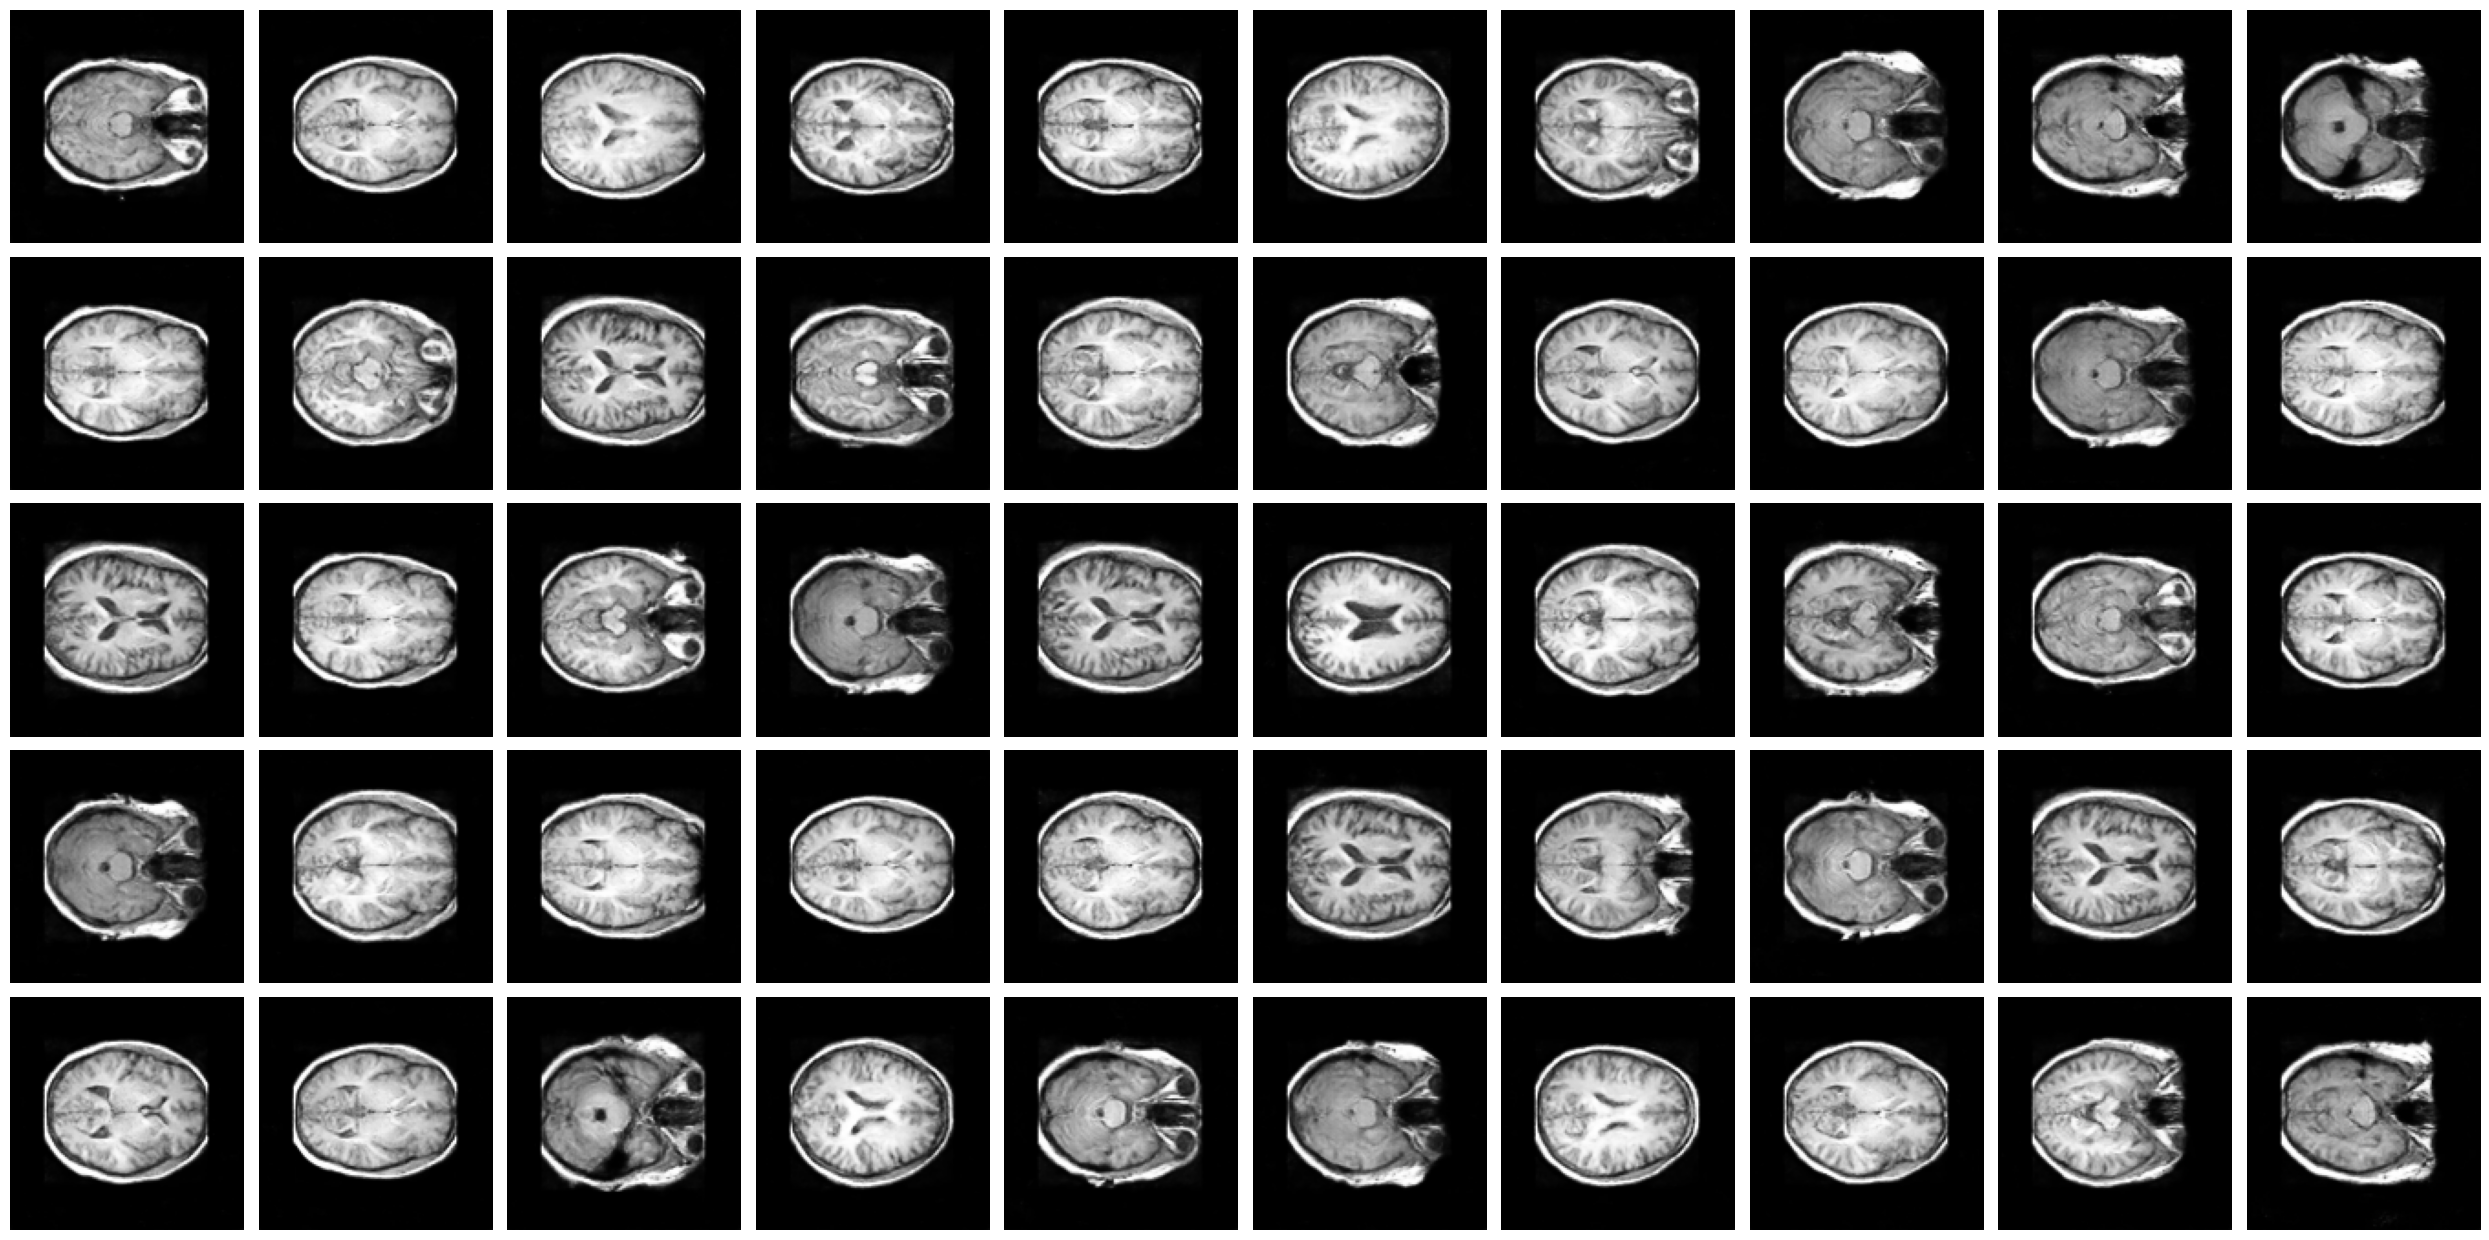

In [9]:
import os
import matplotlib.pyplot as plt

# 1. Define the directory where the inverted images (PNG files) are stored
recovered_dir = "/kaggle/working/recovered"

# 2. Build a sorted list of all .png files in the recovered directory
#    - os.listdir(recovered_dir) returns all filenames in that folder
#    - We filter only those ending with ".png" (case-insensitive)
png_files = sorted([
    os.path.join(recovered_dir, f)
    for f in os.listdir(recovered_dir)
    if f.lower().endswith(".png")
])

# If no PNG files are found, raise an error to alert the user
if len(png_files) == 0:
    raise RuntimeError(f"No .png files found in directory {recovered_dir}")

# 3. Determine how many rows and columns are needed for the grid of subplots
#    - We fix the number of columns to 10
#    - Compute the number of rows: ceiling of (total_images / ncols)
n = len(png_files)
ncols = 10
nrows = (n + ncols - 1) // ncols  # integer division rounding up

# 4. Create a matplotlib figure with a grid of subplots
#    - figsize scales so that each subplot is approximately 2.5×2.5 inches
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2.5, nrows * 2.5))
axes = axes.flatten()  # Flatten the 2D array of Axes into a 1D list for easy indexing

# 5. Loop over each PNG file and display it in the corresponding subplot
for idx, img_path in enumerate(png_files):
    img = plt.imread(img_path)        # Load the image from disk
    axes[idx].imshow(img, cmap="gray")  # Display in grayscale
    axes[idx].axis("off")               # Turn off axis ticks/labels for a clean look

# 6. For any remaining subplots beyond the number of images, turn off their axes
#    (handles the case where nrows * ncols > total_images)
for j in range(len(png_files), len(axes)):
    axes[j].axis("off")

# Adjust layout to minimize whitespace and then show the figure
plt.tight_layout()
plt.show()
